# Modeling notebook
This notebook contains a CNN model that is used to train our data and evaluation.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!mkdir -p /content/drive/MyDrive/cifar10_project/results

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import random

## 1.Loading data that we saved.

In [3]:
X_train = np.load("/content/drive/MyDrive/cifar10_project/data/X_train.npy")
y_train = np.load("/content/drive/MyDrive/cifar10_project/data/y_train.npy")
X_valid = np.load("/content/drive/MyDrive/cifar10_project/data/X_valid.npy")
y_valid = np.load("/content/drive/MyDrive/cifar10_project/data/y_valid.npy")
X_test = np.load("/content/drive/MyDrive/cifar10_project/data/X_test.npy")
y_test = np.load("/content/drive/MyDrive/cifar10_project/data/y_test.npy")

## 2. Prepare data with tf.data

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

## 3. Building a simple CNN model

In [5]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
])

model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    data_augmentation,
    layers.Conv2D(32, activation="relu", kernel_size=3, kernel_initializer="he_normal", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2),

    layers.Conv2D(64, activation="relu", kernel_size=3, kernel_initializer="he_normal", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2),

    layers.Conv2D(128, activation="relu", kernel_size=3, kernel_initializer="he_normal", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2),

    layers.GlobalAveragePooling2D(),
    layers.Dropout(rate=0.1),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])

## 4. Adding callbacks and train model on data

In [6]:
lr_schedule = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    patience=3,
    factor=0.5,
    verbose=1
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
def train_model(model, train_ds, val_ds, optimizer, epochs, initial_epoch=0):
  model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
  history = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=epochs,
                        initial_epoch=initial_epoch,
                        callbacks=[lr_schedule, early_stop])
  return history.history
history = train_model(model, train_ds, val_ds, optimizer, epochs=25)

Epoch 1/25
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.3781 - loss: 1.7057 - val_accuracy: 0.5252 - val_loss: 1.3371 - learning_rate: 0.0010
Epoch 2/25
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.5288 - loss: 1.3088 - val_accuracy: 0.5490 - val_loss: 1.2654 - learning_rate: 0.0010
Epoch 3/25
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.5790 - loss: 1.1768 - val_accuracy: 0.5822 - val_loss: 1.2052 - learning_rate: 0.0010
Epoch 4/25
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.6128 - loss: 1.0884 - val_accuracy: 0.6590 - val_loss: 0.9667 - learning_rate: 0.0010
Epoch 5/25
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.6340 - loss: 1.0286 - val_accuracy: 0.6572 - val_loss: 0.9817 - learning_rate: 0.0010
Epoch 6/25
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.6553 - loss: 0.9815 - val_accuracy: 0.6818 - val_loss: 0.9229 - learning_rate: 0.0010
Epoch 7/25
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accura

## 5. Continue training for few more epochs with SGD

In [8]:
# changed the optimizer from Nadam to SGD and recompiled it.
new_optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
history2 = train_model(model, train_ds, val_ds, new_optimizer, epochs=40, initial_epoch=25)

Epoch 26/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7658 - loss: 0.6595 - val_accuracy: 0.7836 - val_loss: 0.6253 - learning_rate: 0.0010
Epoch 27/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7739 - loss: 0.6479 - val_accuracy: 0.7812 - val_loss: 0.6378 - learning_rate: 0.0010
Epoch 28/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7782 - loss: 0.6317 - val_accuracy: 0.7880 - val_loss: 0.6150 - learning_rate: 0.0010
Epoch 29/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.7787 - loss: 0.6345 - val_accuracy: 0.7902 - val_loss: 0.6138 - learning_rate: 0.0010
Epoch 30/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7772 - loss: 0.6298 - val_accuracy: 0.7814 - val_loss: 0.6303 - learning_rate: 0.0010
Epoch 31/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7828 - loss: 0.6230 - val_accuracy: 0.7886 - val_loss: 0.6137 - learning_rate: 0.0010
Epoch 32/40
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accurac

## 6. Save model and history

In [11]:
import pickle


model.save("/content/drive/MyDrive/cifar10_project/results/simple_CNN_model_v1.keras")

with open("/content/drive/MyDrive/cifar10_project/results/history_nadam.pkl", "wb") as f:
    pickle.dump(history, f)

with open("/content/drive/MyDrive/cifar10_project/results/history_sgd.pkl", "wb") as f:
    pickle.dump(history2, f)

In [12]:
with open("/content/drive/MyDrive/cifar10_project/results/history_nadam.pkl", "rb") as f:
    history1 = pickle.load(f)

with open("/content/drive/MyDrive/cifar10_project/results/history_sgd.pkl", "rb") as f:
    history2 = pickle.load(f)

## 7. Merge histories and plot accuracy and loss per epoch

In [13]:
def merge_histories(hist1, hist2):
    merged = {
        "accuracy": hist1["accuracy"] + hist2["accuracy"],
        "val_accuracy": hist1["val_accuracy"] + hist2["val_accuracy"],
        "loss": hist1["loss"] + hist2["loss"],
        "val_loss": hist1["val_loss"] + hist2["val_loss"]
    }
    return merged

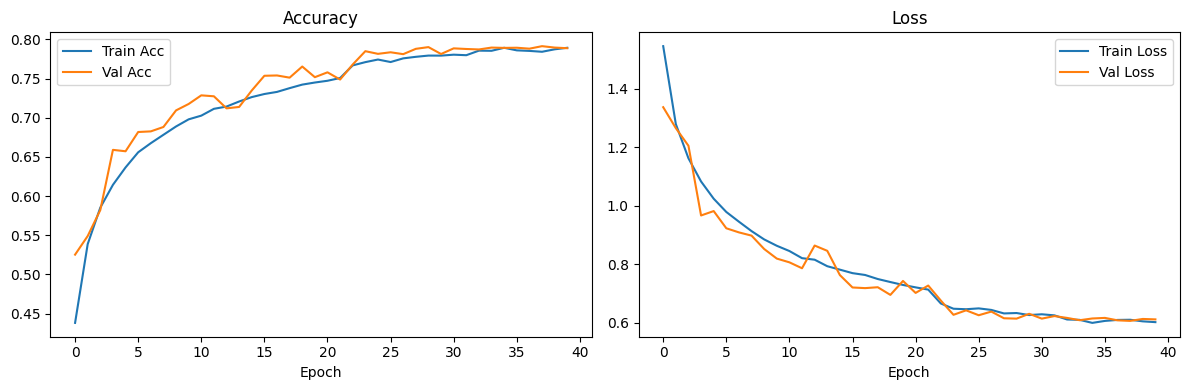

In [14]:
merged_history = merge_histories(history1, history2)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(merged_history["accuracy"], label="Train Acc")
plt.plot(merged_history["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(merged_history["loss"], label="Train Loss")
plt.plot(merged_history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/cifar10_project/results/CNN_accuracy_loss.png")
plt.show()

## 8. Evaluate model on test set

In [16]:
model = models.load_model("/content/drive/MyDrive/cifar10_project/results/simple_CNN_model_v1.keras")

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7834 - loss: 0.6315
Test Accuracy: 0.7856, Test Loss: 0.6347


## 9. Confusion matrix, f1-score, precision and recall

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


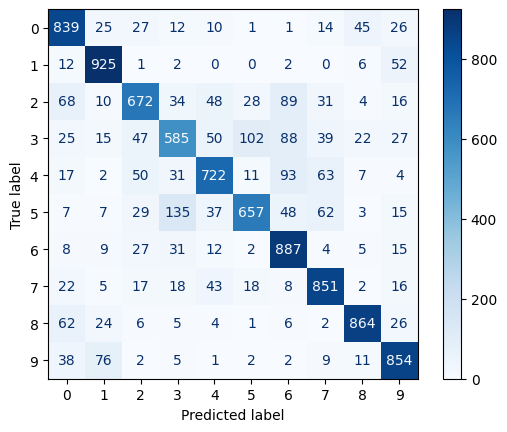

In [17]:
# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.savefig("/content/drive/MyDrive/cifar10_project/results/confusion_matrix.png")
plt.show()

In [18]:
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7641    0.8390    0.7998      1000
           1     0.8424    0.9250    0.8818      1000
           2     0.7654    0.6720    0.7157      1000
           3     0.6818    0.5850    0.6297      1000
           4     0.7789    0.7220    0.7494      1000
           5     0.7993    0.6570    0.7212      1000
           6     0.7247    0.8870    0.7977      1000
           7     0.7916    0.8510    0.8202      1000
           8     0.8916    0.8640    0.8776      1000
           9     0.8126    0.8540    0.8328      1000

    accuracy                         0.7856     10000
   macro avg     0.7852    0.7856    0.7826     10000
weighted avg     0.7852    0.7856    0.7826     10000



## 10. Display some of predictions

/tmp/ipython-input-711116161.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = class_names[int(y_true[idx])]


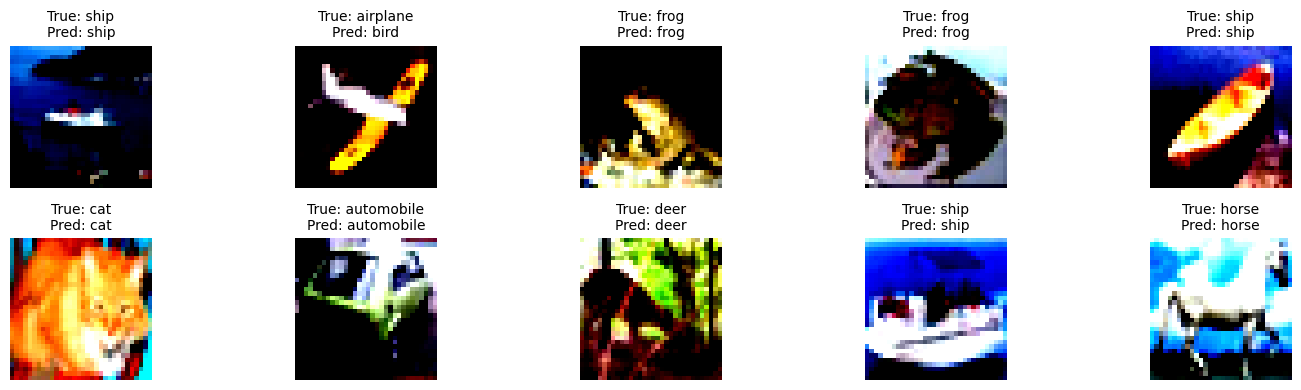

In [19]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

indices = random.sample(range(len(X_test)), 10)
plt.figure(figsize=(15, 4))

for i, idx in enumerate(indices):
    img = X_test[idx]
    true_label = class_names[int(y_true[idx])]
    pred_label = class_names[int(y_pred[idx])]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()
